In [ ]:
!pip install pyyaml h5py seaborn numpy matplotlib hmmlearn pandas


     |████████████████████████████████| 368kB 3.5MB/s 


In [1]:
from discretize import Data
from lstm import train, load_model, prepare_data, plot_sensor_predictions
bathroom1 = Data.parse('bathroom1')
kitchen1 = Data.parse('kitchen1')
combined = bathroom1.combine(kitchen1)
model = train(combined, epochs=180, lookback=40, dt=600, shift_direction=-1, with_time=False)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/content/discretize.py:66: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  activity_labels = pd.read_csv('{:s}.activity_labels.csv'.format(prefix), delimiter=',,')
/content/discretize.py:67: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sensor_labels = pd.read_csv('{:s}.sensor_labels.csv'.format(prefix), delimiter=',,')


Epoch 1/180


ValueError: ignored

## Suggestions

---


Compile the model using Keras's APIs and fetch accuracy, loss and other evaluation metrics

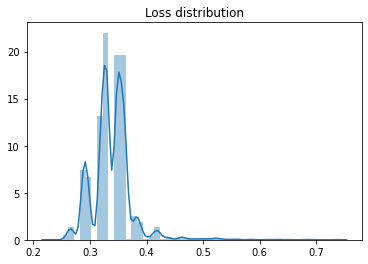

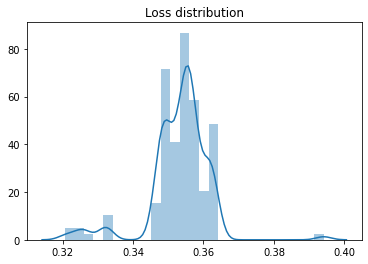

(144, 11)


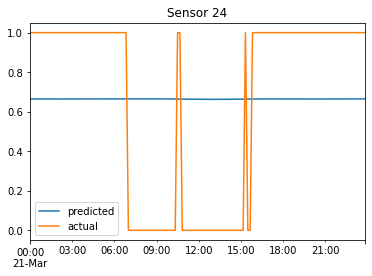

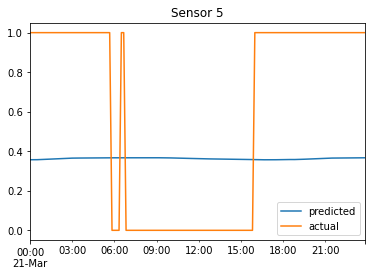

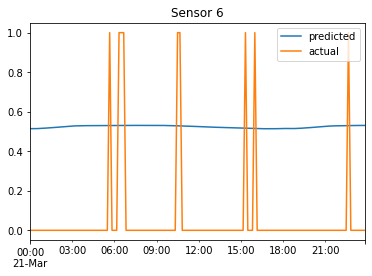

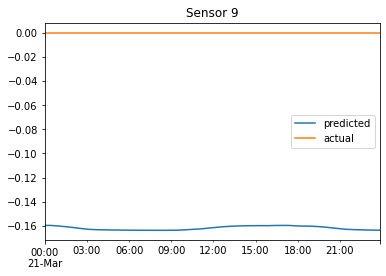

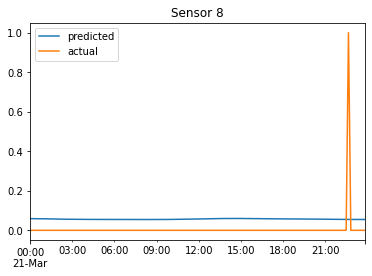

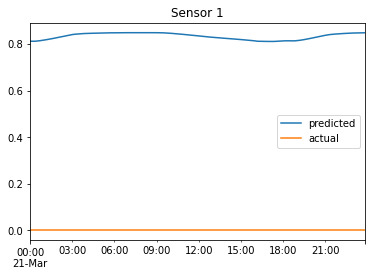

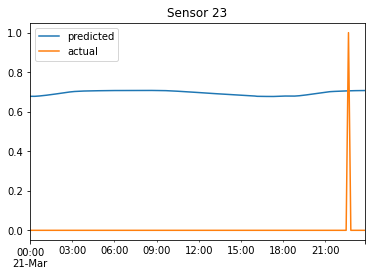

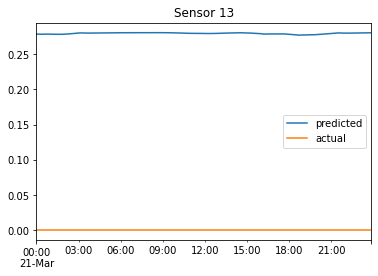

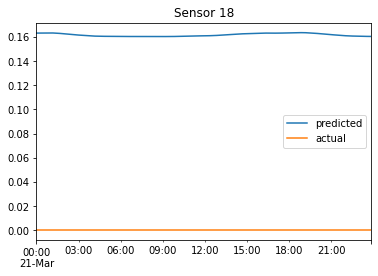

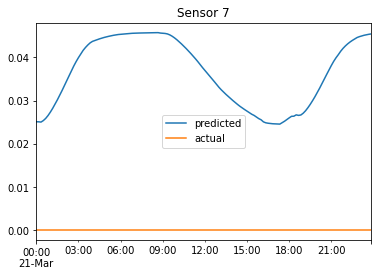

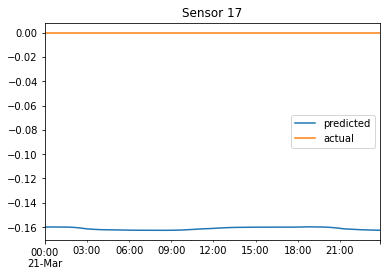

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
dt=600
X = prepare_data(combined, window_size=40, dt=600, shift_direction=-1, with_time=False)
X_test = X[-(3600//dt)*24:]
X_train = X[:-(3600//dt)*24]
n_features = X.shape[2]  # 59
lr = 0.0004
model = load_model(40, n_features, lr, 'lstm_autoencoder_classifier.h5')
X_pred = model.predict(X_train)
X_pred = X_pred[:,0,:].reshape(X_train.shape[0], X_train.shape[2])
Xtrain = X_train[:,0,:].reshape(X_train.shape[0], X_train.shape[2])

fig, ax = plt.subplots()
ax.set_title("Loss distribution")
sns.distplot(np.mean(np.abs(X_pred-Xtrain), axis=1), ax=ax)
plt.show()

X_pred = model.predict(X_test)
X_pred = X_pred[:,0,:].reshape(X_test.shape[0], X_test.shape[2])
Xtest = X_test[:,0,:].reshape(X_test.shape[0], X_test.shape[2])

fig, ax = plt.subplots()
ax.set_title("Loss distribution")
sns.distplot(np.mean(np.abs(X_pred-Xtest), axis=1), ax=ax)
plt.show()

print(Xtest.shape)

plot_sensor_predictions(combined, 600, X_pred, Xtest, 40, False)

(1440, 11)
Int64Index([24, 5, 6, 9, 8, 1, 23, 13, 18, 7, 17], dtype='int64')


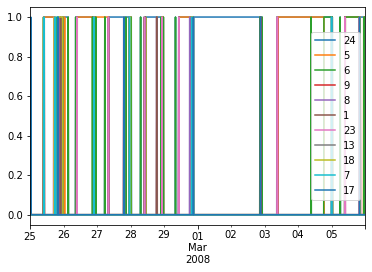

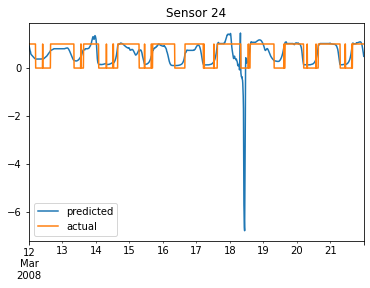

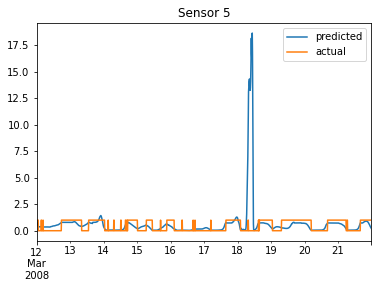

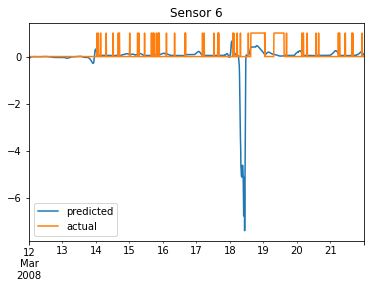

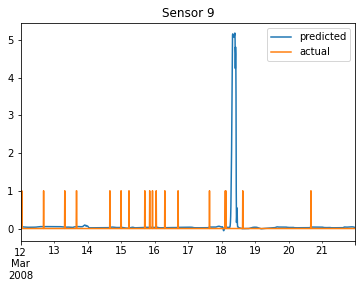

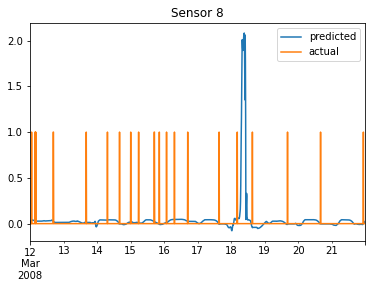

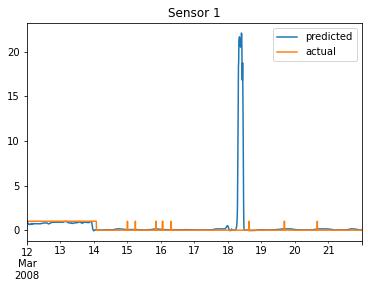

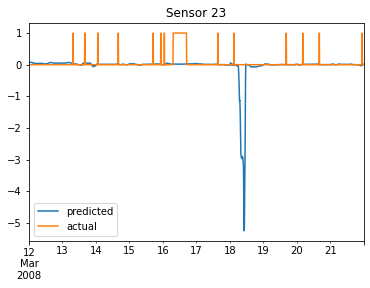

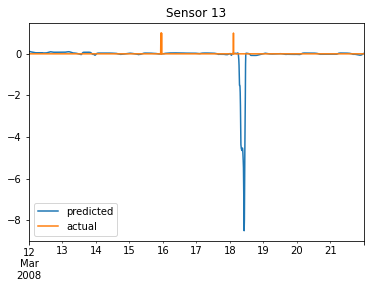

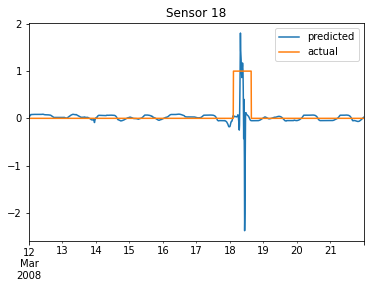

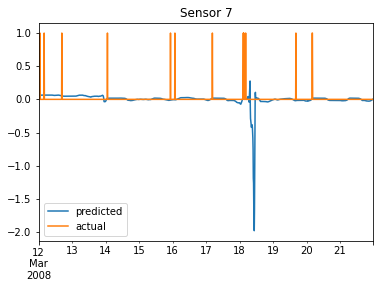

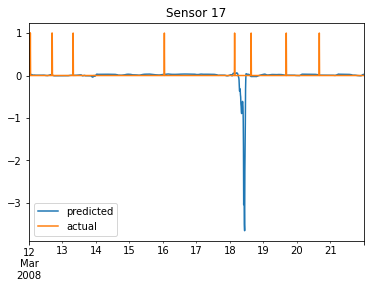

In [ ]:
import pandas as pd
data = combined.sensor_values_reshape(600)
anomaly = np.mean(np.abs(X_pred-Xtest), axis=1) > 0.025

time = np.arange(
    start=pd.Timestamp(combined.sensor_data.start_time.min().date()),
    stop=pd.Timestamp(combined.sensor_data.end_time.max().date() + pd.Timedelta(1, 'day')),
    step=pd.to_timedelta(600, 's')
).astype('datetime64[ns]')
data.index = time
print(X_pred.shape)
print(data.columns)
time = time[40:]
X_test_time = time[-60*24:]
# df = pd.DataFrame(X_pred[:,:-1]-Xtest[:,:-1], columns=data.columns, index=X_test_time)
# df_pred = pd.DataFrame(X_pred[:,:-1], columns=data.columns, index=X_test_time)
# df_test = pd.DataFrame(Xtest[:,:-1], columns=data.columns, index=X_test_time)
df = pd.DataFrame(X_pred-Xtest, columns=data.columns, index=X_test_time)
df_pred = pd.DataFrame(X_pred, columns=data.columns, index=X_test_time)
df_test = pd.DataFrame(Xtest, columns=data.columns, index=X_test_time)

# print(X_test_time[anomaly])
series_sensor_data = combined.sensor_values_reshape(600)
# series_sensor_data.head(1000)
# print(df.head(1000))
# df.plot()
# plt.show()
data.head(24*60).plot()
plt.show()
for i in df.columns:
  d2 = pd.DataFrame()
  d2['predicted'] = df_pred[i]
  d2['actual'] = df_test[i]
  d2.plot()
  plt.legend()
  plt.title("Sensor %d" % i)
  plt.show()

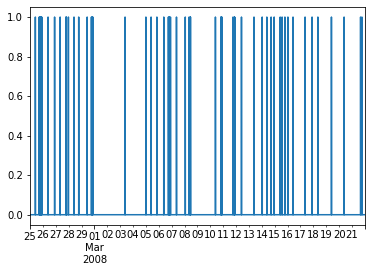

In [ ]:
data[8].plot()
plt.show()
